# Wireless localization with diffusion maps

Na pocetku cemo pozvati korisne pakete i definirati neke funkcije koje cemo koristit u ostatku

In [95]:
import numpy as np
from numpy.random import seed
from numpy.random import shuffle
import matplotlib.pyplot as plt
import scipy
import random

Funkcija koja računa običnu euklidsku udaljenost u vektorskom prostoru proizvoljne dimenzije

In [96]:
def euclidean_distance(pointA, pointB):
    n = len(pointA)
    res = 0
    for i in range(0, n):
        res = res + (pointA[i] - pointB[i]) ** 2
    res = res ** 0.5
    return res

Funkcija koja računa matricu udaljenosti D', tj. udaljenost između danih pozicija, kao argument prima numpy array sa koordinatama pozicija, a vraća matricu dimenzija (M, M) međusobnih udaljenosti

In [97]:
def position_distance(pozicije):
    M = np.shape(pozicije)[0]

    D_positions = np.zeros([M, M])
    for i in range(0, M):
        for j in range(0, M):
            D_positions[i, j] = euclidean_distance(pozicije[i], pozicije[j])
    return D_positions

Funkcija koja prima broj senzora M, te vraća matricu senzora dimenzije (M, 2) sa slučajno pridruženim pozicijama koje su zapisane u drugom stupcu, dok je u prvom stupcu ID senzora

In [98]:
def get_sensor(M):
    # na slucajan nacin cemo izmijesati niz elemenata od 1 do M
    sequence = [i for i in range(1, M + 1)]
    shuffle(sequence)

    senzori = np.zeros([M, 2])
    for i in range(0, M):
        senzori[i, 0] = i + 1
        senzori[i, 1] = sequence[i]
    return senzori

Funkcija koja računa čisti, noiseless RSSI pomocu matrica 'D_positions' i 'senzori', za racunanje čistog RSSI-a cemo koristiti inverse square law propagation model

Ciste RSSI vrijednosti cemo pohraniti u 'RSSI_noiseless' matricu koja ce biti dimenzija (M, M)

In [99]:
def get_RSSI_noiseless_square(D_positions, senzori):
    M = np.shape(senzori)[0]
    RSSI_noiseless = np.zeros([M, M])

    for i in range(0, M):
        for j in range(0, M):
            RSSI_noiseless[i, j] = 1/(D_positions[int(senzori[i, 1]) - 1, int(senzori[j, 1]) - 1] ** 2 + 0.1)
    return RSSI_noiseless

Gaussian kernel

In [100]:
def gaussian_kernel(d, sigma):
    return np.exp(-d**2 / sigma)

Funkcija koja racuna matricu slicnosti C

In [101]:
def get_C(D):
    C = np.zeros(np.shape(D))
    M = np.shape(D)[0]

    sigma = 1/(M**2) * np.sum(np.power(D, 2))
    for i in range(0, M):
        for j in range(0, M):
            if(i == j):
                C[i, j] = 0
            else:
                C[i, j] = gaussian_kernel(D[i, j], sigma)
    return C

Funkcija koja racuna Laplacian matricu L

In [102]:
def get_L(C):
    L = np.zeros(np.shape(C))
    M = np.shape(C)[0]
    
    for i in range(0, M):
        for j in range(0, M):
            if(i == j):
                L[i, j] = 1
            else:
                L[i, j] = -C[i, j] / np.sum(C[i, :])
    return L

Funkcija koja računa svojstvenu dekompoziciju od Laplacian matrice te vraća k svojstvenih vektora spremljenih kao stupce matrice keigvec dimenzija (M, k) koji odgovaraju k najmanjih pozitivnih svojstvenih vrijednosti

In [103]:
def get_keigvec(L, k):
    w, v = np.linalg.eig(L)
    w = np.asarray(w)
    v = np.asarray(v)
    
    idx = np.argsort(w)
    keigvec = v[:,idx[1:k+1]]
    return keigvec

## Primjer 1

 Prvo cemo definirati poznate pozicije

In [104]:
x = 10
y = 8
pozicije = []
for i in range(0, x):
    for j in range(0, y):
        pozicije.append([i+1, j+1])
pozicije = np.asarray(pozicije)
print(pozicije)
print(np.shape(pozicije))
print(type(pozicije))

[[ 1  1]
 [ 1  2]
 [ 1  3]
 [ 1  4]
 [ 1  5]
 [ 1  6]
 [ 1  7]
 [ 1  8]
 [ 2  1]
 [ 2  2]
 [ 2  3]
 [ 2  4]
 [ 2  5]
 [ 2  6]
 [ 2  7]
 [ 2  8]
 [ 3  1]
 [ 3  2]
 [ 3  3]
 [ 3  4]
 [ 3  5]
 [ 3  6]
 [ 3  7]
 [ 3  8]
 [ 4  1]
 [ 4  2]
 [ 4  3]
 [ 4  4]
 [ 4  5]
 [ 4  6]
 [ 4  7]
 [ 4  8]
 [ 5  1]
 [ 5  2]
 [ 5  3]
 [ 5  4]
 [ 5  5]
 [ 5  6]
 [ 5  7]
 [ 5  8]
 [ 6  1]
 [ 6  2]
 [ 6  3]
 [ 6  4]
 [ 6  5]
 [ 6  6]
 [ 6  7]
 [ 6  8]
 [ 7  1]
 [ 7  2]
 [ 7  3]
 [ 7  4]
 [ 7  5]
 [ 7  6]
 [ 7  7]
 [ 7  8]
 [ 8  1]
 [ 8  2]
 [ 8  3]
 [ 8  4]
 [ 8  5]
 [ 8  6]
 [ 8  7]
 [ 8  8]
 [ 9  1]
 [ 9  2]
 [ 9  3]
 [ 9  4]
 [ 9  5]
 [ 9  6]
 [ 9  7]
 [ 9  8]
 [10  1]
 [10  2]
 [10  3]
 [10  4]
 [10  5]
 [10  6]
 [10  7]
 [10  8]]
(80, 2)
<class 'numpy.ndarray'>


Vizualni prikaz

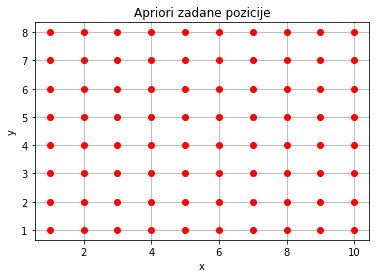

In [105]:
plt.plot(pozicije[:, 0], pozicije[:, 1], 'ro')
plt.title("Apriori zadane pozicije")
plt.ylabel('y')
plt.xlabel('x')
plt.grid()
plt.show()

Dakle, ovdje je M = 80

In [106]:
M = np.shape(pozicije)[0]

D_positions = position_distance(pozicije)
D_positions[0, :]

array([ 0.        ,  1.        ,  2.        ,  3.        ,  4.        ,
        5.        ,  6.        ,  7.        ,  1.        ,  1.41421356,
        2.23606798,  3.16227766,  4.12310563,  5.09901951,  6.08276253,
        7.07106781,  2.        ,  2.23606798,  2.82842712,  3.60555128,
        4.47213595,  5.38516481,  6.32455532,  7.28010989,  3.        ,
        3.16227766,  3.60555128,  4.24264069,  5.        ,  5.83095189,
        6.70820393,  7.61577311,  4.        ,  4.12310563,  4.47213595,
        5.        ,  5.65685425,  6.40312424,  7.21110255,  8.06225775,
        5.        ,  5.09901951,  5.38516481,  5.83095189,  6.40312424,
        7.07106781,  7.81024968,  8.60232527,  6.        ,  6.08276253,
        6.32455532,  6.70820393,  7.21110255,  7.81024968,  8.48528137,
        9.21954446,  7.        ,  7.07106781,  7.28010989,  7.61577311,
        8.06225775,  8.60232527,  9.21954446,  9.89949494,  8.        ,
        8.06225775,  8.24621125,  8.54400375,  8.94427191,  9.43

In [107]:
senzori = get_sensor(M)
print(senzori)

[[ 1. 34.]
 [ 2. 69.]
 [ 3. 48.]
 [ 4. 10.]
 [ 5. 55.]
 [ 6. 71.]
 [ 7. 37.]
 [ 8. 38.]
 [ 9.  7.]
 [10. 27.]
 [11. 57.]
 [12. 12.]
 [13. 11.]
 [14. 51.]
 [15.  2.]
 [16. 50.]
 [17. 75.]
 [18. 36.]
 [19. 28.]
 [20. 76.]
 [21. 16.]
 [22.  8.]
 [23. 67.]
 [24.  5.]
 [25. 58.]
 [26. 24.]
 [27. 30.]
 [28. 80.]
 [29. 20.]
 [30. 26.]
 [31. 65.]
 [32. 45.]
 [33. 47.]
 [34.  9.]
 [35. 72.]
 [36. 18.]
 [37. 52.]
 [38. 22.]
 [39. 53.]
 [40. 33.]
 [41.  1.]
 [42. 39.]
 [43. 78.]
 [44.  4.]
 [45. 56.]
 [46. 19.]
 [47. 49.]
 [48. 29.]
 [49. 74.]
 [50. 44.]
 [51. 15.]
 [52.  3.]
 [53.  6.]
 [54. 62.]
 [55. 32.]
 [56. 59.]
 [57. 70.]
 [58. 14.]
 [59. 40.]
 [60. 66.]
 [61. 31.]
 [62. 35.]
 [63. 61.]
 [64. 42.]
 [65. 79.]
 [66. 60.]
 [67. 25.]
 [68. 46.]
 [69. 64.]
 [70. 73.]
 [71. 68.]
 [72. 23.]
 [73. 77.]
 [74. 54.]
 [75. 21.]
 [76. 41.]
 [77. 13.]
 [78. 63.]
 [79. 43.]
 [80. 17.]]


Sada mozemo izracunati cisti, noiseless RSSI pomocu inverse square law propagation modela

In [108]:
RSSI_noiseless = get_RSSI_noiseless_square(D_positions, senzori)
RSSI_noiseless[0, :]

array([10.        ,  0.03984064,  0.02695418,  0.10989011,  0.03436426,
        0.0243309 ,  0.10989011,  0.0621118 ,  0.0243309 ,  0.47619048,
        0.0990099 ,  0.07633588,  0.0990099 ,  0.19607843,  0.0621118 ,
        0.24390244,  0.03831418,  0.24390244,  0.19607843,  0.03436426,
        0.02217295,  0.01919386,  0.05847953,  0.03984064,  0.10989011,
        0.02493766,  0.05847953,  0.01636661,  0.12345679,  0.90909091,
        0.05847953,  0.0990099 ,  0.03831418,  0.0990099 ,  0.01919386,
        0.24390244,  0.12345679,  0.04975124,  0.07633588,  0.90909091,
        0.05847953,  0.03984064,  0.0243309 ,  0.04975124,  0.02493766,
        0.19607843,  0.19607843,  0.0990099 ,  0.03984064,  0.19607843,
        0.02932551,  0.05847953,  0.03115265,  0.03984064,  0.02695418,
        0.0990099 ,  0.03115265,  0.03984064,  0.02770083,  0.0621118 ,
        0.03831418,  0.90909091,  0.05524862,  0.90909091,  0.01996008,
        0.07633588,  0.47619048,  0.05847953,  0.02217295,  0.03

Sada kada imamo noiseless RSSI, mozemo dodati sum, to cemo pospremiti u matricu 'RSSI'

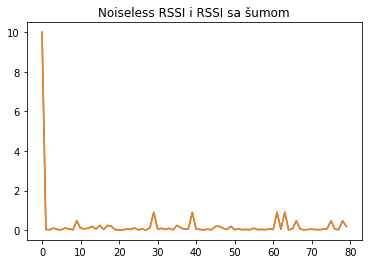

In [109]:
# ovo nisam siguran je li dobro, treba odredit var u N(0, var)...
# ovaj dio ne znam
noise = np.random.normal(0, 0.001 ,[M, M])

RSSI = RSSI_noiseless # + noise

# mogu plotat da vidim
plt.plot(RSSI_noiseless[0, :])
plt.plot(RSSI[0, :])
plt.title("Noiseless RSSI i RSSI sa šumom")
plt.show()

In [110]:
# ovaj dio ce ici poslije
#snr = [1, 3, 5, 10, 30, 50, 75, 100, 150, 200, 250, 300, 500, 600, 700, 800, 900, 1000]
#sigma = np.mean(RSSI_noiseless)/snr

#for i in range(0, len(snr)):
#    for j in range(0, 100):
        

Sada cemo izracunati matricu slicnosti C'

In [111]:
C_positions = get_C(D_positions)
C_positions

array([[0.        , 0.96364044, 0.86230336, ..., 0.01972387, 0.01312373,
        0.00810872],
       [0.96364044, 0.        , 0.96364044, ..., 0.02752687, 0.01972387,
        0.01312373],
       [0.86230336, 0.96364044, 0.        , ..., 0.03567399, 0.02752687,
        0.01972387],
       ...,
       [0.01972387, 0.02752687, 0.03567399, ..., 0.        , 0.96364044,
        0.86230336],
       [0.01312373, 0.01972387, 0.02752687, ..., 0.96364044, 0.        ,
        0.96364044],
       [0.00810872, 0.01312373, 0.01972387, ..., 0.86230336, 0.96364044,
        0.        ]])

Sada imamo matricu slicnosti C', te sada pomocu nje racunamo L'

In [112]:
L_positions = get_L(C_positions)
L_positions

array([[ 1.00000000e+00, -4.03346831e-02, -3.60930603e-02, ...,
        -8.25573348e-04, -5.49314262e-04, -3.39403350e-04],
       [-3.44846928e-02,  1.00000000e+00, -3.44846928e-02, ...,
        -9.85072520e-04, -7.05835304e-04, -4.69643794e-04],
       [-2.78394111e-02, -3.11110728e-02,  1.00000000e+00, ...,
        -1.15173269e-03, -8.88703375e-04, -6.36783794e-04],
       ...,
       [-6.36783794e-04, -8.88703375e-04, -1.15173269e-03, ...,
         1.00000000e+00, -3.11110728e-02, -2.78394111e-02],
       [-4.69643794e-04, -7.05835304e-04, -9.85072520e-04, ...,
        -3.44846928e-02,  1.00000000e+00, -3.44846928e-02],
       [-3.39403350e-04, -5.49314262e-04, -8.25573348e-04, ...,
        -3.60930603e-02, -4.03346831e-02,  1.00000000e+00]])

Sada treba izracunati i pronaci najmanje pozitivne svojstvene vektore matrice L' i stvoriti matricu P

In [113]:
k = 2
P = get_keigvec(L_positions, k)
P

array([[-0.16786436, -0.16448958],
       [-0.16911277, -0.12192146],
       [-0.16985378, -0.0749596 ],
       [-0.17019949, -0.02529215],
       [-0.17019949,  0.02529215],
       [-0.16985378,  0.0749596 ],
       [-0.16911277,  0.12192146],
       [-0.16786436,  0.16448958],
       [-0.13693481, -0.16683413],
       [-0.13780878, -0.12344818],
       [-0.13832735, -0.07582147],
       [-0.13856929, -0.0255709 ],
       [-0.13856929,  0.0255709 ],
       [-0.13832735,  0.07582147],
       [-0.13780878,  0.12344818],
       [-0.13693481,  0.16683413],
       [-0.10149536, -0.16838325],
       [-0.10207478, -0.12445736],
       [-0.1024186 , -0.07639157],
       [-0.10257903, -0.02575537],
       [-0.10257903,  0.02575537],
       [-0.1024186 ,  0.07639157],
       [-0.10207478,  0.12445736],
       [-0.10149536,  0.16838325],
       [-0.06246491, -0.16932902],
       [-0.06279653, -0.12507416],
       [-0.06299333, -0.07674037],
       [-0.06308518, -0.0258683 ],
       [-0.06308518,

Sada pomocu matrice RSSI i propagation modela racunamo matricu node_distance D

In [114]:
D = np.zeros([M,M])

for i in range(0, M):
    for j in range(0, M):
        D[i, j] = np.sqrt((1 - RSSI[i, j]/10) / RSSI[i, j])

Sada nalazimo C, L i N od nodeova

In [115]:
C = get_C(D)
L = get_L(C)
N = get_keigvec(L, k)

Sada imamo za izmijeniti 2**k puta predznake u matrici N i sa svakom izracunati sa mađarskim algoritmom parove i cost

Da bismo koristili mađarski algoritam trebamo kreirati cost matricu dimenzija (M,M) tj. to je matrica ciji je [i,j] element jednak euklidskoj udaljenosti izemđu i-tog nodea i j-te pozicije u difuzijskim koordinatama

In [116]:
cost = np.zeros([M, M])
for i in range(0, M):
    for j in range(0, M):
        cost[i, j] = euclidean_distance(N[i, :], P[j, :])

In [117]:
from munkres import Munkres
from munkres import Munkres, print_matrix

m = Munkres()
indexes = m.compute(cost)
print_matrix(cost, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = cost[row][column]
    total += value
    print(f'({row+1}, {column+1}) -> {value}')
print(f'total cost: {total}')

Lowest cost through this matrix:
[  0.3460679390227762,  0.31204382612470793,  0.27682680090558376,  0.24358301657406953,  0.21598481703781694,  0.19759329855967314,  0.19034558276536256,  0.19307120230673372,  0.33224820546009615,   0.2952854607407685,   0.2567614852333932,  0.21979335432923136,   0.1883775150348124,  0.16704578102943946,   0.1590219772511731,  0.16348278029494906,   0.3183457230472204,  0.27858478844723705,  0.23661919601115275,  0.19534519345350074,   0.1588842584207725,  0.13296838086004517,  0.12327975847808638,  0.13001888897513547,   0.3063430686649092,  0.26415273403554357,  0.21894370157798887,  0.17313724769121958,  0.13040068059377324,  0.09722848773756466,  0.08399865913385889,  0.09451302242245896,   0.2981607502386909,  0.25429507356106074,   0.2066836947653999,  0.15714492403229335,  0.10814525788478656,  0.06443564407313193, 0.042403239347294445,  0.06132865722996975,  0.29514566166860934,   0.2507348195410466,  0.20227376570346747,  0.15128950753575485

Usporedba pridruzenih pozicija mađarskim algoritmom i pravih pozicija

In [125]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 47.]
 [ 2. 12.]
 [ 3. 33.]
 [ 4. 71.]
 [ 5. 26.]
 [ 6. 10.]
 [ 7. 44.]
 [ 8. 43.]
 [ 9. 74.]
 [10. 54.]
 [11. 24.]
 [12. 69.]
 [13. 70.]
 [14. 30.]
 [15. 79.]
 [16. 31.]
 [17.  6.]
 [18. 45.]
 [19. 53.]
 [20.  5.]
 [21. 65.]
 [22. 73.]
 [23. 14.]
 [24. 76.]
 [25. 23.]
 [26. 57.]
 [27. 51.]
 [28.  1.]
 [29. 61.]
 [30. 55.]
 [31. 16.]
 [32. 36.]
 [33. 34.]
 [34. 72.]
 [35.  9.]
 [36. 63.]
 [37. 29.]
 [38. 59.]
 [39. 28.]
 [40. 48.]
 [41. 80.]
 [42. 42.]
 [43.  3.]
 [44. 77.]
 [45. 25.]
 [46. 62.]
 [47. 32.]
 [48. 52.]
 [49.  7.]
 [50. 37.]
 [51. 66.]
 [52. 78.]
 [53. 75.]
 [54. 19.]
 [55. 49.]
 [56. 22.]
 [57. 11.]
 [58. 67.]
 [59. 41.]
 [60. 15.]
 [61. 50.]
 [62. 46.]
 [63. 20.]
 [64. 39.]
 [65.  2.]
 [66. 21.]
 [67. 56.]
 [68. 35.]
 [69. 17.]
 [70.  8.]
 [71. 13.]
 [72. 58.]
 [73.  4.]
 [74. 27.]
 [75. 60.]
 [76. 40.]
 [77. 68.]
 [78. 18.]
 [79. 38.]
 [80. 64.]]
[[ 1. 34.]
 [ 2. 69.]
 [ 3. 48.]
 [ 4. 10.]
 [ 5. 55.]
 [ 6. 71.]
 [ 7. 37.]
 [ 8. 38.]
 [ 9.  7.]
 [10. 27.]
 [11. 57.

Mogu probat sad preostala 3 slucaja, da izvrtim predznake

1.slucaj: 1.koordinata u -

In [128]:
N[:,0] = -N[:,0]

array([[-0.02120162,  0.12536741],
       [ 0.13856929, -0.0255709 ],
       [ 0.02109357, -0.16977823],
       [-0.13780878,  0.12344818],
       [ 0.06279653, -0.12507416],
       [ 0.13780878, -0.12344818],
       [-0.02129569, -0.02592207],
       [-0.02126575, -0.07690635],
       [-0.16911277, -0.12192146],
       [-0.06299333,  0.07674037],
       [ 0.10149536,  0.16838325],
       [-0.13856929,  0.0255709 ],
       [-0.13832735,  0.07582147],
       [ 0.06299333,  0.07674037],
       [-0.16911277,  0.12192146],
       [ 0.06279653,  0.12507416],
       [ 0.16985378,  0.0749596 ],
       [-0.02129569,  0.02592207],
       [-0.06308518,  0.0258683 ],
       [ 0.17019949,  0.02529215],
       [-0.13693481, -0.16683413],
       [-0.16786436, -0.16448958],
       [ 0.13832735,  0.07582147],
       [-0.17019949, -0.02529215],
       [ 0.10207478,  0.12445736],
       [-0.10149536, -0.16838325],
       [-0.06299333, -0.07674037],
       [ 0.16786436, -0.16448958],
       [-0.10257903,

In [129]:
cost = np.zeros([M, M])
for i in range(0, M):
    for j in range(0, M):
        cost[i, j] = euclidean_distance(N[i, :], P[j, :])

m = Munkres()
indexes = m.compute(cost)
print_matrix(cost, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = cost[row][column]
    total += value
    print(f'({row+1}, {column+1}) -> {value}')
print(f'total cost: {total}')

Lowest cost through this matrix:
[  0.3248492466487869,    0.288148383716152,  0.24945616232628154,   0.2118930552394524,  0.17948655126845967,  0.15696627299719054,  0.14795128419168685,   0.1517909871796742,  0.31428635178848097,  0.27478432694242333,  0.23279906476199716,  0.19120027378090315,  0.15406009949785268,  0.12717404300618093,   0.1166229491017322,  0.12293762785260288,   0.3045267398098512,  0.26258880730283646,  0.21749226079170472,  0.17164025809720096,  0.12862675137080518,   0.0948410770281768,  0.08087828025464941,  0.09109032532101163,  0.29757124658418577,  0.25387224054975965,  0.20638338552873547,   0.1569282452037126,  0.10795510689145317,  0.06411814243538969,  0.04159594162401587,  0.06029330379122681,   0.2951456616686098,   0.2507348195410471,  0.20227376570346775,  0.15128950753575526,  0.09944538573640842,   0.0484611064370558,                  0.0,  0.04441095378995401,   0.2981607502386912,  0.25429507356106096,  0.20668369476540027,  0.15714492403229366

In [130]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 39.]
 [ 2. 68.]
 [ 3. 41.]
 [ 4. 15.]
 [ 5. 50.]
 [ 6. 66.]
 [ 7. 36.]
 [ 8. 35.]
 [ 9.  2.]
 [10. 30.]
 [11. 64.]
 [12. 13.]
 [13. 14.]
 [14. 54.]
 [15.  7.]
 [16. 55.]
 [17. 78.]
 [18. 37.]
 [19. 29.]
 [20. 77.]
 [21.  9.]
 [22.  1.]
 [23. 70.]
 [24.  4.]
 [25. 63.]
 [26. 17.]
 [27. 27.]
 [28. 73.]
 [29. 21.]
 [30. 31.]
 [31. 72.]
 [32. 44.]
 [33. 42.]
 [34. 16.]
 [35. 65.]
 [36. 23.]
 [37. 53.]
 [38. 19.]
 [39. 52.]
 [40. 40.]
 [41.  8.]
 [42. 34.]
 [43. 75.]
 [44.  5.]
 [45. 49.]
 [46. 22.]
 [47. 56.]
 [48. 28.]
 [49. 79.]
 [50. 45.]
 [51. 10.]
 [52.  6.]
 [53.  3.]
 [54. 59.]
 [55. 25.]
 [56. 62.]
 [57. 67.]
 [58. 11.]
 [59. 33.]
 [60. 71.]
 [61. 26.]
 [62. 38.]
 [63. 60.]
 [64. 47.]
 [65. 74.]
 [66. 61.]
 [67. 32.]
 [68. 43.]
 [69. 57.]
 [70. 80.]
 [71. 69.]
 [72. 18.]
 [73. 76.]
 [74. 51.]
 [75. 20.]
 [76. 48.]
 [77. 12.]
 [78. 58.]
 [79. 46.]
 [80. 24.]]
[[ 1. 34.]
 [ 2. 69.]
 [ 3. 48.]
 [ 4. 10.]
 [ 5. 55.]
 [ 6. 71.]
 [ 7. 37.]
 [ 8. 38.]
 [ 9.  7.]
 [10. 27.]
 [11. 57.

2. slucaj: 2. koordinata u -

In [131]:
N[:,0] = -N[:,0] # da vratimo zbog 1. slucaja
N[:,1] = -N[:,1]

In [132]:
cost = np.zeros([M, M])
for i in range(0, M):
    for j in range(0, M):
        cost[i, j] = euclidean_distance(N[i, :], P[j, :])

m = Munkres()
indexes = m.compute(cost)
print_matrix(cost, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = cost[row][column]
    total += value
    print(f'({row+1}, {column+1}) -> {value}')
print(f'total cost: {total}')

Lowest cost through this matrix:
[  0.1930712023067336,  0.19034558276536379,  0.19759329855967384,  0.21598481703781755,  0.24358301657407117,  0.27682680090558365,  0.31204382612470755,   0.3460679390227778,   0.1634827802949496,  0.15902197725117376,  0.16704578102944023,  0.18837751503481323,   0.2197933543292315,   0.2567614852333935,  0.29528546074076917,   0.3322482054600966,  0.13001888897513597,  0.12327975847808721,  0.13296838086004578,  0.15888425842077272,  0.19534519345350104,  0.23661919601115305,    0.278584788447237,  0.31834572304722086,  0.09451302242245978,  0.08399865913385936,  0.09722848773756519,  0.13040068059377358,  0.17313724769121985,  0.21894370157798923,  0.26415273403554373,   0.3063430686649092,  0.06132865722996984,  0.04240323934729496,  0.06443564407313258,  0.10814525788478682,  0.15714492403229363,  0.20668369476540036,    0.254295073561061,  0.29816075023869143, 0.044410953789953495,                  0.0,  0.04846110643705586,   0.0994453857364084

In [133]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 42.]
 [ 2. 13.]
 [ 3. 40.]
 [ 4. 66.]
 [ 5. 31.]
 [ 6. 15.]
 [ 7. 45.]
 [ 8. 46.]
 [ 9. 79.]
 [10. 51.]
 [11. 17.]
 [12. 68.]
 [13. 67.]
 [14. 27.]
 [15. 74.]
 [16. 26.]
 [17.  3.]
 [18. 44.]
 [19. 52.]
 [20.  4.]
 [21. 72.]
 [22. 80.]
 [23. 11.]
 [24. 77.]
 [25. 18.]
 [26. 64.]
 [27. 54.]
 [28.  8.]
 [29. 60.]
 [30. 50.]
 [31.  9.]
 [32. 37.]
 [33. 39.]
 [34. 65.]
 [35. 16.]
 [36. 58.]
 [37. 28.]
 [38. 62.]
 [39. 29.]
 [40. 41.]
 [41. 73.]
 [42. 47.]
 [43.  6.]
 [44. 76.]
 [45. 32.]
 [46. 59.]
 [47. 25.]
 [48. 53.]
 [49.  2.]
 [50. 36.]
 [51. 71.]
 [52. 75.]
 [53. 78.]
 [54. 22.]
 [55. 56.]
 [56. 19.]
 [57. 14.]
 [58. 70.]
 [59. 48.]
 [60. 10.]
 [61. 55.]
 [62. 43.]
 [63. 21.]
 [64. 34.]
 [65.  7.]
 [66. 20.]
 [67. 49.]
 [68. 38.]
 [69. 24.]
 [70.  1.]
 [71. 12.]
 [72. 63.]
 [73.  5.]
 [74. 30.]
 [75. 61.]
 [76. 33.]
 [77. 69.]
 [78. 23.]
 [79. 35.]
 [80. 57.]]
[[ 1. 34.]
 [ 2. 69.]
 [ 3. 48.]
 [ 4. 10.]
 [ 5. 55.]
 [ 6. 71.]
 [ 7. 37.]
 [ 8. 38.]
 [ 9.  7.]
 [10. 27.]
 [11. 57.

Zadnji slucaj: obje koordinate u -

In [134]:
N[:,0] = -N[:,0]

array([[-0.02120162, -0.12536741],
       [ 0.13856929,  0.0255709 ],
       [ 0.02109357,  0.16977823],
       [-0.13780878, -0.12344818],
       [ 0.06279653,  0.12507416],
       [ 0.13780878,  0.12344818],
       [-0.02129569,  0.02592207],
       [-0.02126575,  0.07690635],
       [-0.16911277,  0.12192146],
       [-0.06299333, -0.07674037],
       [ 0.10149536, -0.16838325],
       [-0.13856929, -0.0255709 ],
       [-0.13832735, -0.07582147],
       [ 0.06299333, -0.07674037],
       [-0.16911277, -0.12192146],
       [ 0.06279653, -0.12507416],
       [ 0.16985378, -0.0749596 ],
       [-0.02129569, -0.02592207],
       [-0.06308518, -0.0258683 ],
       [ 0.17019949, -0.02529215],
       [-0.13693481,  0.16683413],
       [-0.16786436,  0.16448958],
       [ 0.13832735, -0.07582147],
       [-0.17019949,  0.02529215],
       [ 0.10207478, -0.12445736],
       [-0.10149536,  0.16838325],
       [-0.06299333,  0.07674037],
       [ 0.16786436,  0.16448958],
       [-0.10257903,

In [135]:
cost = np.zeros([M, M])
for i in range(0, M):
    for j in range(0, M):
        cost[i, j] = euclidean_distance(N[i, :], P[j, :])

m = Munkres()
indexes = m.compute(cost)
print_matrix(cost, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = cost[row][column]
    total += value
    print(f'({row+1}, {column+1}) -> {value}')
print(f'total cost: {total}')

Lowest cost through this matrix:
[ 0.15179098717967354,  0.14795128419168763,  0.15696627299719076,  0.17948655126846003,   0.2118930552394537,  0.24945616232628104,  0.28814838371615115,   0.3248492466487881,  0.12293762785260294,  0.11662294910173243,   0.1271740430061813,  0.15406009949785307,  0.19120027378090293,  0.23279906476199705,  0.27478432694242355,    0.314286351788481,  0.09109032532101163,  0.08087828025464977,  0.09484107702817698,  0.12862675137080495,  0.17164025809720082,  0.21749226079170464,  0.26258880730283596,   0.3045267398098512,  0.06029330379122706, 0.041595941624015864,  0.06411814243538977,  0.10795510689145307,  0.15692824520371246,  0.20638338552873542,   0.2538722405497593,   0.2975712465841853, 0.044410953789953446,                  0.0,  0.04846110643705586,  0.09944538573640822,   0.1512895075357551,  0.20227376570346783,   0.2507348195410469,   0.2951456616686099,  0.06132865722996956, 0.042403239347294557,  0.06443564407313222,  0.10814525788478682

In [136]:
indexes=np.asarray(indexes)
print(indexes+np.ones([M,2]))
print(senzori)

[[ 1. 34.]
 [ 2. 69.]
 [ 3. 48.]
 [ 4. 10.]
 [ 5. 55.]
 [ 6. 71.]
 [ 7. 37.]
 [ 8. 38.]
 [ 9.  7.]
 [10. 27.]
 [11. 57.]
 [12. 12.]
 [13. 11.]
 [14. 51.]
 [15.  2.]
 [16. 50.]
 [17. 75.]
 [18. 36.]
 [19. 28.]
 [20. 76.]
 [21. 16.]
 [22.  8.]
 [23. 67.]
 [24.  5.]
 [25. 58.]
 [26. 24.]
 [27. 30.]
 [28. 80.]
 [29. 20.]
 [30. 26.]
 [31. 65.]
 [32. 45.]
 [33. 47.]
 [34.  9.]
 [35. 72.]
 [36. 18.]
 [37. 52.]
 [38. 22.]
 [39. 53.]
 [40. 33.]
 [41.  1.]
 [42. 39.]
 [43. 78.]
 [44.  4.]
 [45. 56.]
 [46. 19.]
 [47. 49.]
 [48. 29.]
 [49. 74.]
 [50. 44.]
 [51. 15.]
 [52.  3.]
 [53.  6.]
 [54. 62.]
 [55. 32.]
 [56. 59.]
 [57. 70.]
 [58. 14.]
 [59. 40.]
 [60. 66.]
 [61. 31.]
 [62. 35.]
 [63. 61.]
 [64. 42.]
 [65. 79.]
 [66. 60.]
 [67. 25.]
 [68. 46.]
 [69. 64.]
 [70. 73.]
 [71. 68.]
 [72. 23.]
 [73. 77.]
 [74. 54.]
 [75. 21.]
 [76. 41.]
 [77. 13.]
 [78. 63.]
 [79. 43.]
 [80. 17.]]
[[ 1. 34.]
 [ 2. 69.]
 [ 3. 48.]
 [ 4. 10.]
 [ 5. 55.]
 [ 6. 71.]
 [ 7. 37.]
 [ 8. 38.]
 [ 9.  7.]
 [10. 27.]
 [11. 57.

BINGO!